In [89]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras


def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period / period)
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level




In [90]:
import pandas as pd
import os


os.chdir(r'D:\PythonProjects\Neural Network\Sequence,Prediction')

Table = pd.read_csv('Sunspots.csv', index_col=0)
Table.rename(columns={
    'Date': 'time_step',
    'Monthly Mean Total Sunspot Number': 'sunspots'
},
             inplace=True)
Table

,time_step,sunspots
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3260,2020-09-30,0.6
3261,2020-10-31,14.4
3262,2020-11-30,34.0
3263,2020-12-31,21.8


In [91]:
series = Table.sunspots.values
time = Table.time_step.values

In [92]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 64
shuffle_buffer_size = 1000

In [93]:
import tensorflow as tf


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [94]:
dataset = windowed_dataset(series, window_size, batch_size,
                           shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=5,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
history = model.fit(dataset, epochs=100, verbose=0)


D:\Python\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



ValueError: in user code:

    D:\Python\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    D:\Python\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\Python\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\Python\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\Python\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\Python\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    D:\Python\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    D:\Python\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    D:\Python\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:230 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_9 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, None)


In [ ]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
result = np.array(forecast)[:, 0, 0]

Text(0.5, 1.0, 'mae=13.167768478393555')

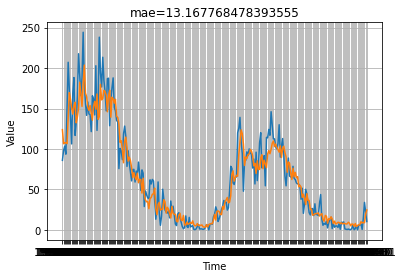

In [ ]:
plot_series(time_valid, x_valid)
plot_series(time_valid, result)

plt.title(f'mae={tf.keras.metrics.mean_absolute_error(x_valid, result).numpy()}')

In [ ]:
import plotly.express as px

valid = pd.DataFrame({'time_valid' : time_valid, 'x_valid' : x_valid})

predict = pd.DataFrame({'time_valid' : time_valid, 'result' : result})

px.line(valid,
        x=time_valid,
        y=x_valid,
        )
px.line(
    predict,
    x=time_valid,
    y=result,
    title=f'mae={tf.keras.metrics.mean_absolute_error(x_valid, result).numpy()}'
)
# import plotly
# import plotly.graph_objs as go

# plotly.offline.init_notebook_mode(connected=True)

# #iplot方法会在jupyter中显示图片
# plotly.offline.iplot({
#     "data": [go.plot(x=time_valid, y=x_valid)],
#     "layout": go.Layout(title="hello world")
# })